# Инициализация

In [40]:
import numpy as np
from matplotlib import pylab as plt

import optimizers
from importlib import reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [242]:
d = 100
mu = 1
L = 1000
sigma = 10

matrix = optimizers.generate_matrix(d, mu, L)
vector = np.random.random_sample(d)

In [299]:
def quadratic(x):
    return 1./2 * x.T @ matrix @ x - vector.T @ x

def quadratic_noisy(x):
    xi = sigma * np.random.standard_normal(1)
    return 1./2 * x.T @ matrix @ x - vector.T @ x + xi

def gradient_true(x, func, gamma_func, d, k, norma):
    grad = matrix @ x - vector
    e = 2 * np.random.random_sample(d) - 1
    e = e / np.linalg.norm(e, ord=norma)
    i = np.random.randint(d)
    return grad, 2, i, e

In [216]:
def const_step(k):
    if k > 100000:
        return 10 / (4 * d * L * (k // 1000))
    elif k > 10000:
        return 10 / (4 * d * L * (k // 10000))
    else:
        return 10 / (4 * d * L)
    

def fw_step(k):
    return 2 / (k + 2)

def momentum_fw(k):
    return (k + 1) / (k + 3)

def momentum_k(k):
    return k / (k + 1)

# Эксперименты FW с разной оценкой градиента на квадратичной задаче

## TPF

### l1-ball

In [249]:
reload(optimizers)

w_0 = np.random.random_sample(d)

### l_1 ball ###
w_0_l1 = w_0 / np.linalg.norm(w_0, ord=1)

_, _, w_sol_l1 = optimizers.GDOptimizer(
    w_0_l1, 
    gradient_true, 
    const_step, 
    quadratic,
    eps = -1000,
    use_proj = True,
    set_name = 'l1_ball', 
    x_sol = w_0_l1,
    max_oracle_calls = 100000
).search()

R_0_l1 = quadratic(w_0_l1) - quadratic(w_sol_l1)

100%|███████████████████████████████████████████████████████| 100000/100000 [02:21<00:00, 706.43it/s]


In [307]:
reload(optimizers)

get_grads = [
    optimizers.get_grad_tpf_jaguar,
    optimizers.get_grad_tpf,
    optimizers.get_grad_tpf_full
    # gradient_true
] # * 3
# step_funcs = [
#     const_step,
#     const_step,
#     const_step
# ]
step_funcs = [
    fw_step,
    fw_step,
    fw_step
]
use_jaguars = [
    True,
    False, 
    False
]

errors = []
oracle_calls = []

for get_grad, step_func, use_jaguar in zip(get_grads, step_funcs, use_jaguars):
    errors_, oracle_calls_, _ = optimizers.FWOptimizer(
        w_0_l1, 
        get_grad, 
        step_func, 
        quadratic_noisy,
        function_without_noise = quadratic,
        eps=-1000,
        set_name='l1_ball',
        use_jaguar = use_jaguar,
        x_sol = w_sol_l1,
        max_oracle_calls = 100000
    ).search()
    errors.append(errors_ / R_0_l1)
    oracle_calls.append(oracle_calls_)
    


 50%|███████████████████████████▌                           | 50000/100000 [00:05<00:05, 8541.42it/s]


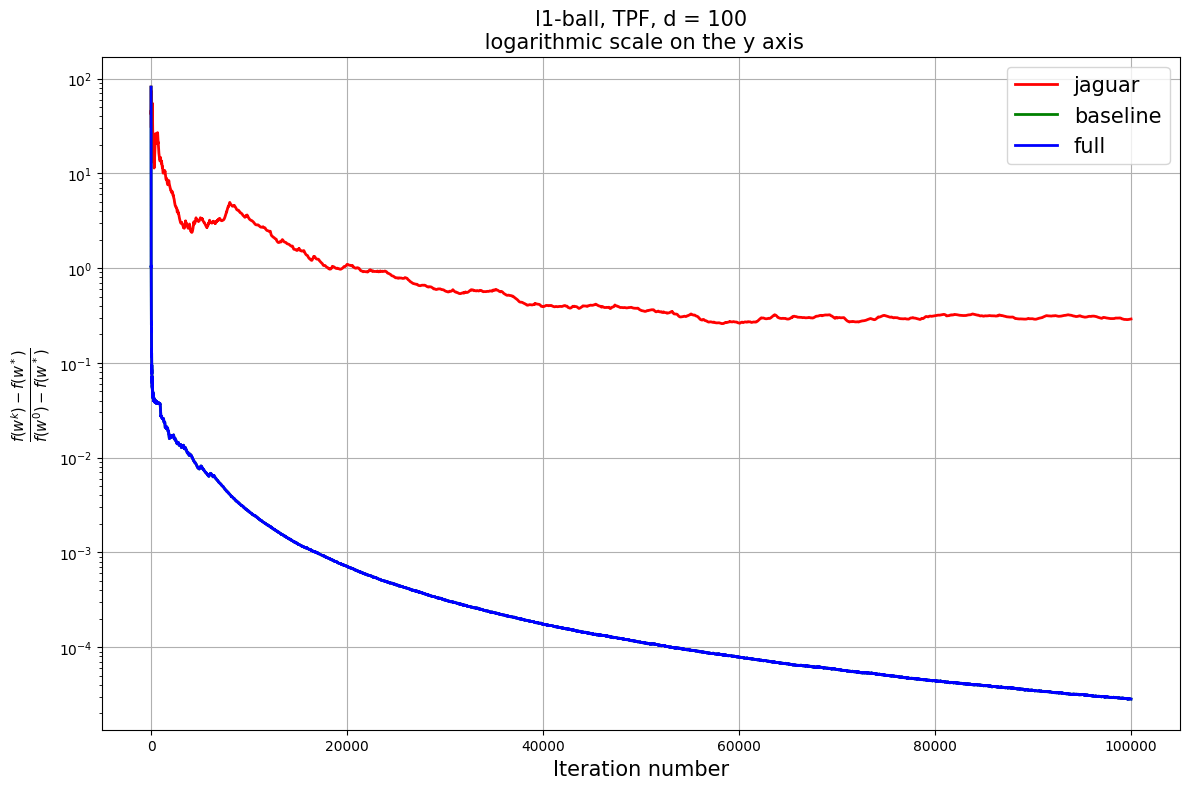

In [308]:
title = f"l1-ball, TPF, d = {d}"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'
labels = [
    'jaguar',
    'baseline',
    'full'
]
iterations = range(1, len(errors) + 1)

optimizers.make_err_plot(oracle_calls, errors, y_label=y_label, labels=labels, title=title)

### l2-ball

In [252]:
reload(optimizers)

w_0 = np.random.random_sample(d)

### l_2 ball ###
w_0_l2 = w_0 / np.linalg.norm(w_0, ord=2)

_, _, w_sol_l2 = optimizers.GDOptimizer(
    w_0_l2, 
    gradient_true, 
    const_step, 
    quadratic_noisy,
    function_without_noise = quadratic,
    eps = -1000,
    use_proj = True,
    set_name = 'l2_ball', 
    x_sol = w_0_l2,
    max_oracle_calls = 1000000
).search()

R_0_l2 = quadratic(w_0_l2) - quadratic(w_sol_l2)

100%|███████████████████████████████████████████████████| 1000000/1000000 [01:36<00:00, 10409.67it/s]


In [312]:
reload(optimizers)

get_grads = [
    optimizers.get_grad_tpf_jaguar,
    optimizers.get_grad_tpf,
    optimizers.get_grad_tpf_full
    # gradient_true
] # * 3
step_funcs = [
    fw_step,
    fw_step,
    fw_step
]
use_jaguars = [
    True,
    False, 
    False
]

errors = []
oracle_calls = []

for get_grad, step_func, use_jaguar in zip(get_grads, step_funcs, use_jaguars):
    errors_, oracle_calls_, _ = optimizers.FWOptimizer(
        w_0_l2, 
        get_grad, 
        step_func, 
        quadratic_noisy,
        function_without_noise = quadratic,
        eps=-1000,
        set_name='l2_ball',
        use_jaguar = use_jaguar,
        x_sol = w_sol_l2,
        max_oracle_calls = 100000
    ).search()
    errors.append(errors_ / R_0_l2)
    oracle_calls.append(oracle_calls_)
    


 50%|███████████████████████████▌                           | 50000/100000 [00:05<00:05, 9620.06it/s]


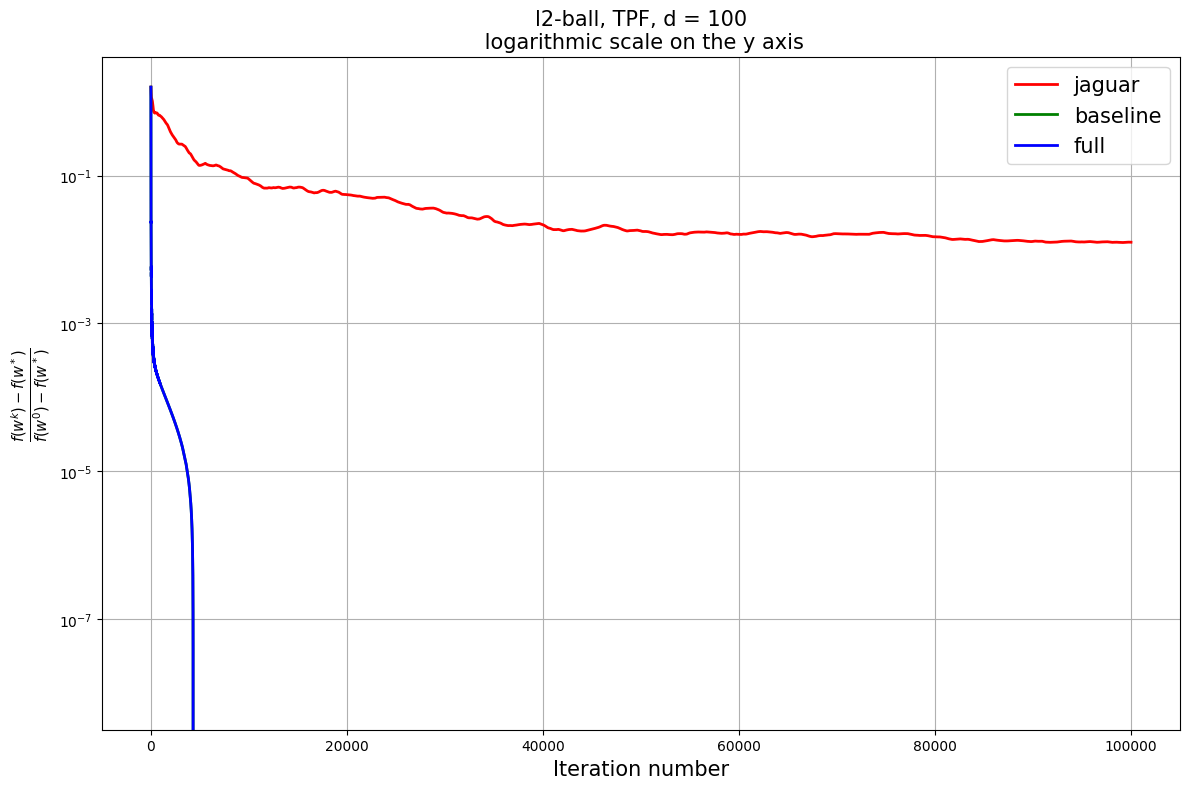

In [313]:
title = f"l2-ball, TPF, d = {d}"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'
labels = [
    'jaguar',
    'baseline',
    'full'
]
iterations = range(1, len(errors) + 1)

optimizers.make_err_plot(oracle_calls, errors, y_label=y_label, labels=labels, title=title)

### simplex

In [256]:
reload(optimizers)

w_0 = np.random.random_sample(d)

### simplex ###
w_0_s = np.abs(w_0) / np.linalg.norm(w_0, ord=1)

_, _, w_sol_s = optimizers.GDOptimizer(
    w_0_s, 
    gradient_true, 
    const_step, 
    quadratic,
    eps = -1000,
    use_proj = True,
    set_name = 'simplex', 
    x_sol = w_0_s,
    max_oracle_calls = 100000
).search()

R_0_s = quadratic(w_0_s) - quadratic(w_sol_s)

100%|██████████████████████████████████████████████████████| 100000/100000 [00:35<00:00, 2820.44it/s]


In [258]:
reload(optimizers)

get_grads = [
    optimizers.get_grad_tpf_jaguar,
    optimizers.get_grad_tpf,
    optimizers.get_grad_tpf_full
]
step_funcs = [
    fw_step,
    fw_step,
    fw_step
]
use_jaguars = [
    True,
    False, 
    False
]

errors = []
oracle_calls = []

for get_grad, step_func, use_jaguar in zip(get_grads, step_funcs, use_jaguars):
    errors_, oracle_calls_, _ = optimizers.FWOptimizer(
        w_0_s, 
        get_grad, 
        step_func, 
        quadratic_noisy,
        function_without_noise = quadratic,
        eps=-1000,
        set_name='simplex',
        use_jaguar = use_jaguar,
        x_sol = w_sol_s,
        max_oracle_calls = 100000
    ).search()
    errors.append(errors_ / R_0_s)
    oracle_calls.append(oracle_calls_)
    


  0%|▎                                                         | 500/100000 [00:04<15:59, 103.74it/s]


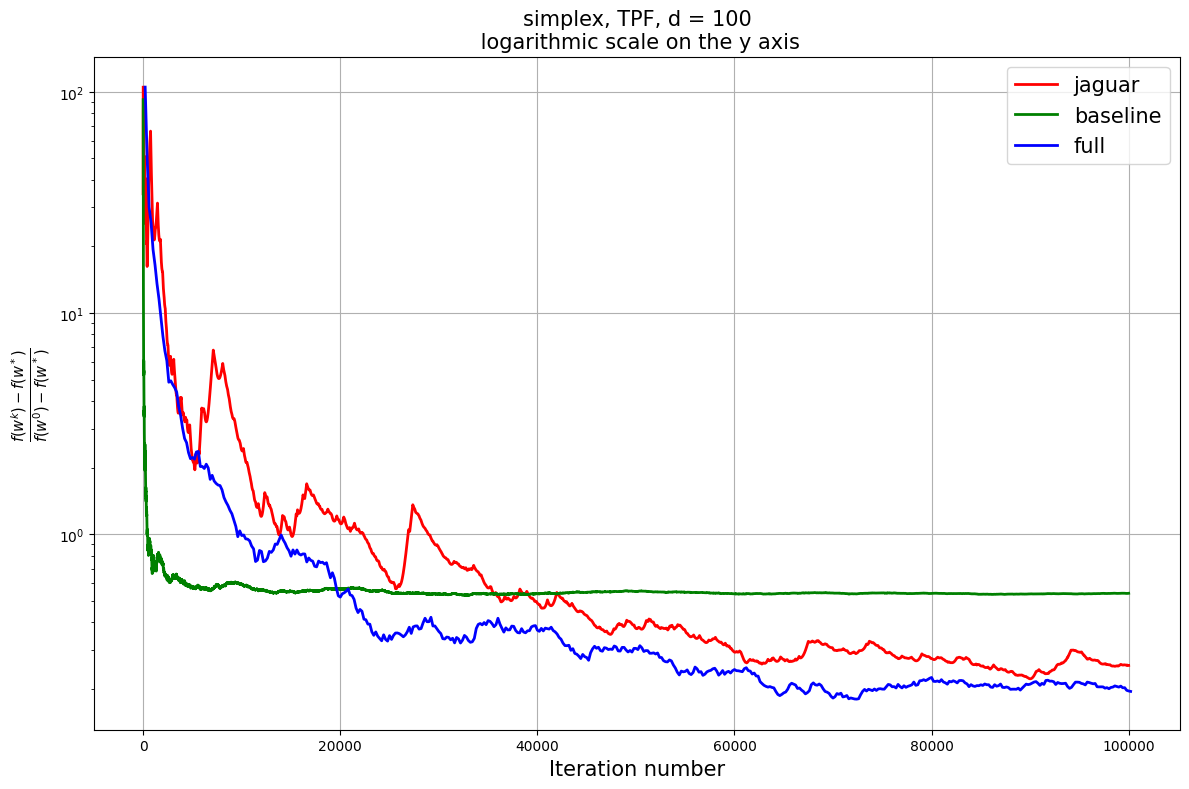

In [259]:
title = f"simplex, TPF, d = {d}"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'
labels = [
    'jaguar',
    'baseline',
    'full'
]
iterations = range(1, len(errors) + 1)

optimizers.make_err_plot(oracle_calls, errors, y_label=y_label, labels=labels, title=title)

## OPF

### l1-ball

In [261]:
reload(optimizers)

w_0 = np.random.random_sample(d)

### l_1 ball ###
w_0_l1 = w_0 / np.linalg.norm(w_0, ord=1)

_, _, w_sol_l1 = optimizers.GDOptimizer(
    w_0_l1, 
    gradient_true, 
    const_step, 
    quadratic,
    eps = -1000,
    use_proj = True,
    set_name = 'l1_ball', 
    x_sol = w_0_l1,
    max_oracle_calls = 100000
).search()

R_0_l1 = quadratic(w_0_l1) - quadratic(w_sol_l1)

100%|███████████████████████████████████████████████████████| 100000/100000 [02:47<00:00, 597.34it/s]


In [264]:
reload(optimizers)

get_grads = [
    optimizers.get_grad_opf_jaguar,
    optimizers.get_grad_opf
]
step_funcs = [
    fw_step,
    fw_step
]
use_jaguars = [
    True,
    False
]

errors = []
oracle_calls = []

for get_grad, step_func, use_jaguar in zip(get_grads, step_funcs, use_jaguars):
    errors_, oracle_calls_, _ = optimizers.FWOptimizer(
        w_0_l1, 
        get_grad, 
        step_func, 
        quadratic_noisy,
        function_without_noise = quadratic,
        eps=-1000,
        set_name='l1_ball',
        use_jaguar = use_jaguar,
        x_sol = w_sol_l1,
        max_oracle_calls = 50000
    ).search()
    errors.append(errors_ / R_0_l1)
    oracle_calls.append(oracle_calls_)
    


100%|████████████████████████████████████████████████████████| 50000/50000 [00:10<00:00, 4830.00it/s]


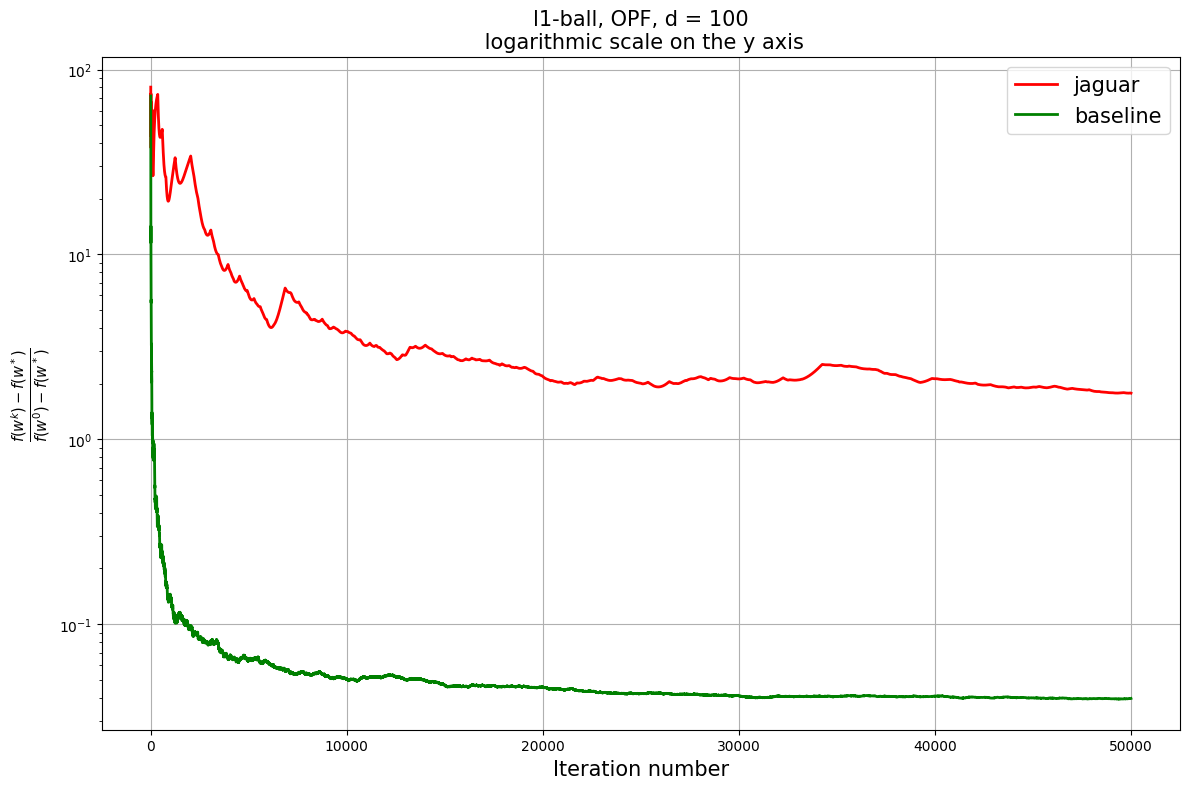

In [265]:
title = f"l1-ball, OPF, d = {d}"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'
labels = [
    'jaguar',
    'baseline'
]
iterations = range(1, len(errors) + 1)

optimizers.make_err_plot(oracle_calls, errors, y_label=y_label, labels=labels, title=title)

### l2-ball

In [266]:
reload(optimizers)

w_0 = np.random.random_sample(d)

### l_2 ball ###
w_0_l2 = w_0 / np.linalg.norm(w_0, ord=2)

_, _, w_sol_l2 = optimizers.GDOptimizer(
    w_0_l2, 
    gradient_true, 
    const_step, 
    quadratic,
    eps = -1000,
    use_proj = True,
    set_name = 'l2_ball', 
    x_sol = w_0_l2,
    max_oracle_calls = 100000
).search()

R_0_l2 = quadratic(w_0_l2) - quadratic(w_sol_l2)

100%|██████████████████████████████████████████████████████| 100000/100000 [00:12<00:00, 7697.52it/s]


In [267]:
reload(optimizers)

get_grads = [
    optimizers.get_grad_opf_jaguar,
    optimizers.get_grad_opf
]
step_funcs = [
    fw_step,
    fw_step
]
use_jaguars = [
    True,
    False
]

errors = []
oracle_calls = []

for get_grad, step_func, use_jaguar in zip(get_grads, step_funcs, use_jaguars):
    errors_, oracle_calls_, _ = optimizers.FWOptimizer(
        w_0_l2, 
        get_grad, 
        step_func, 
        quadratic_noisy,
        function_without_noise = quadratic,
        eps=-1000,
        set_name='l2_ball',
        use_jaguar = use_jaguar,
        x_sol = w_sol_l2,
        max_oracle_calls = 100000
    ).search()
    errors.append(errors_ / R_0_l2)
    oracle_calls.append(oracle_calls_)
    


100%|██████████████████████████████████████████████████████| 100000/100000 [00:22<00:00, 4516.30it/s]


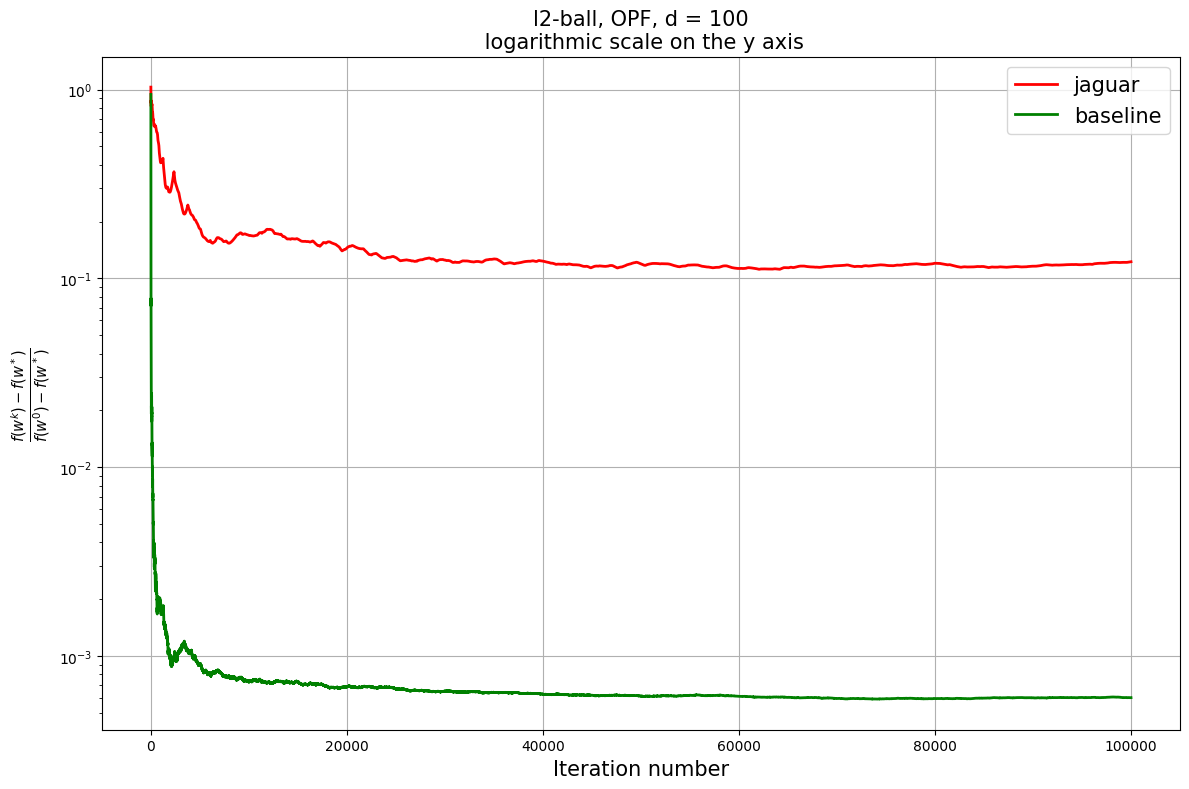

In [268]:
title = f"l2-ball, OPF, d = {d}"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'
labels = [
    'jaguar',
    'baseline',
    'full'
]
iterations = range(1, len(errors) + 1)

optimizers.make_err_plot(oracle_calls, errors, y_label=y_label, labels=labels, title=title)

### simplex

In [269]:
reload(optimizers)

w_0 = np.random.random_sample(d)

### simplex ###
w_0_s = np.abs(w_0) / np.linalg.norm(w_0, ord=1)

_, _, w_sol_s = optimizers.GDOptimizer(
    w_0_s, 
    gradient_true, 
    const_step, 
    quadratic,
    eps = -1000,
    use_proj = True,
    set_name = 'simplex', 
    x_sol = w_0_s,
    max_oracle_calls = 100000
).search()

R_0_s = quadratic(w_0_s) - quadratic(w_sol_s)

100%|██████████████████████████████████████████████████████| 100000/100000 [00:38<00:00, 2590.21it/s]


In [270]:
reload(optimizers)

get_grads = [
    optimizers.get_grad_opf_jaguar,
    optimizers.get_grad_opf
]
step_funcs = [
    fw_step,
    fw_step
]
use_jaguars = [
    True,
    False
]

errors = []
oracle_calls = []

for get_grad, step_func, use_jaguar in zip(get_grads, step_funcs, use_jaguars):
    errors_, oracle_calls_, _ = optimizers.FWOptimizer(
        w_0_s, 
        get_grad, 
        step_func, 
        quadratic_noisy,
        function_without_noise = quadratic,
        eps=-1000,
        set_name='simplex',
        use_jaguar = use_jaguar,
        x_sol = w_sol_s,
        max_oracle_calls = 100000
    ).search()
    errors.append(errors_ / R_0_s)
    oracle_calls.append(oracle_calls_)
    

100%|██████████████████████████████████████████████████████| 100000/100000 [00:19<00:00, 5090.03it/s]


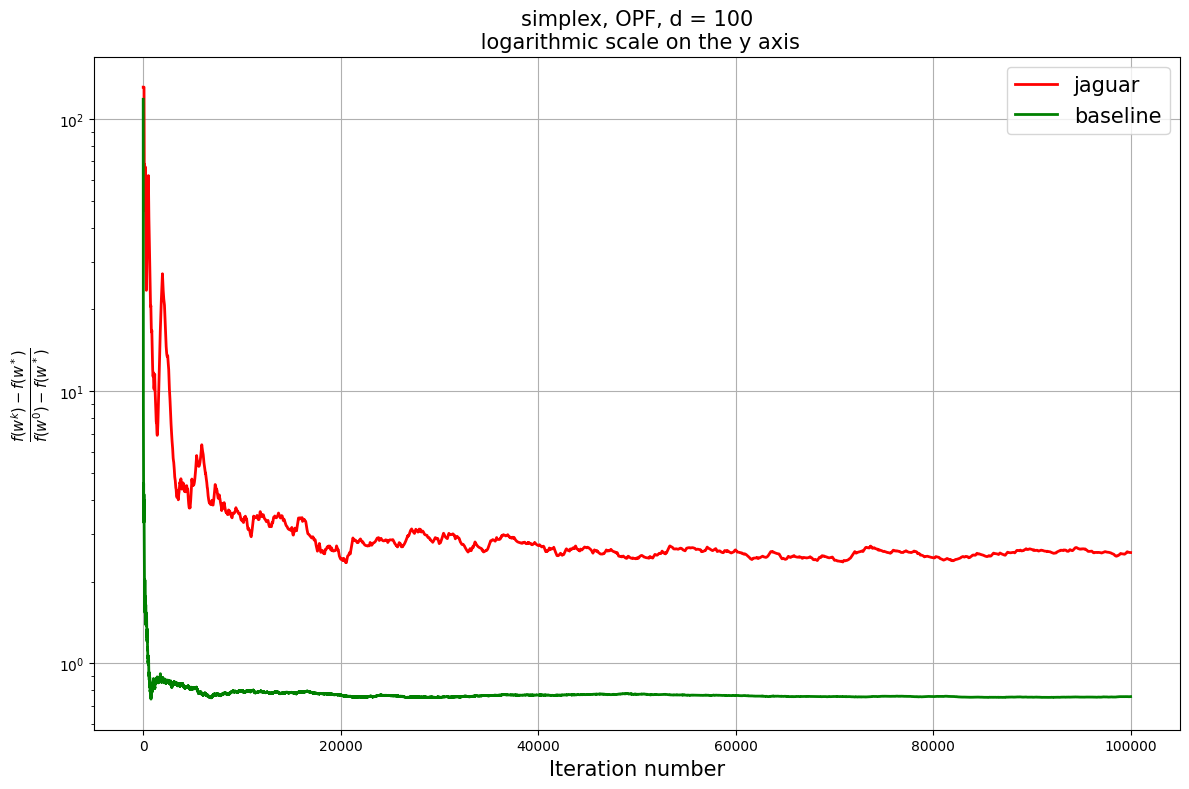

In [271]:
title = f"simplex, OPF, d = {d}"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'
labels = [
    'jaguar',
    'baseline'
]
iterations = range(1, len(errors) + 1)

optimizers.make_err_plot(oracle_calls, errors, y_label=y_label, labels=labels, title=title)

In [284]:
!say give me my money beznos please beznos please beznos

# Квадратичная задача без ограничений

In [285]:
reload(optimizers)

w_0 = np.random.random_sample(d)
w_sol = np.linalg.inv(matrix) @ vector

R_0 = quadratic(w_0) - quadratic(w_sol)

In [309]:
def jaguar_step(k):
    # if k > 10000:
    #     return 1 / (4 * d * L * (k // 10000))
    # else:
    #     return 1 / (4 * d * L)
    return 1 / (14 * d * L)
    
def coord_step(k):
    return 1 / (14 * d * L)
    
def sega_step(k):
    return 1 / (14 * d * L)

In [310]:
reload(optimizers)

step_funcs = [
    jaguar_step,
    coord_step,
    sega_step
]
use_jaguars = [
    True,
    False, 
    False
]
algorithms = [
    optimizers.GDOptimizer,
    optimizers.CDOptimizer,
    optimizers.SEGAOptimizer
]

errors = []
oracle_calls = []

for step_func, use_jaguar, algorithm in zip(step_funcs, use_jaguars, algorithms):
    errors_, oracle_calls_, _ = algorithm(
        w_0, 
        gradient_true, 
        step_func, 
        quadratic_noisy,
        function_without_noise = quadratic,
        eps=-1000,
        use_jaguar = use_jaguar,
        x_sol = w_sol,
        max_oracle_calls = 10000
    ).search()
    errors.append(errors_ / R_0)
    oracle_calls.append(oracle_calls_)

 50%|████████████████████████████▌                            | 5000/10000 [00:00<00:00, 6538.85it/s]


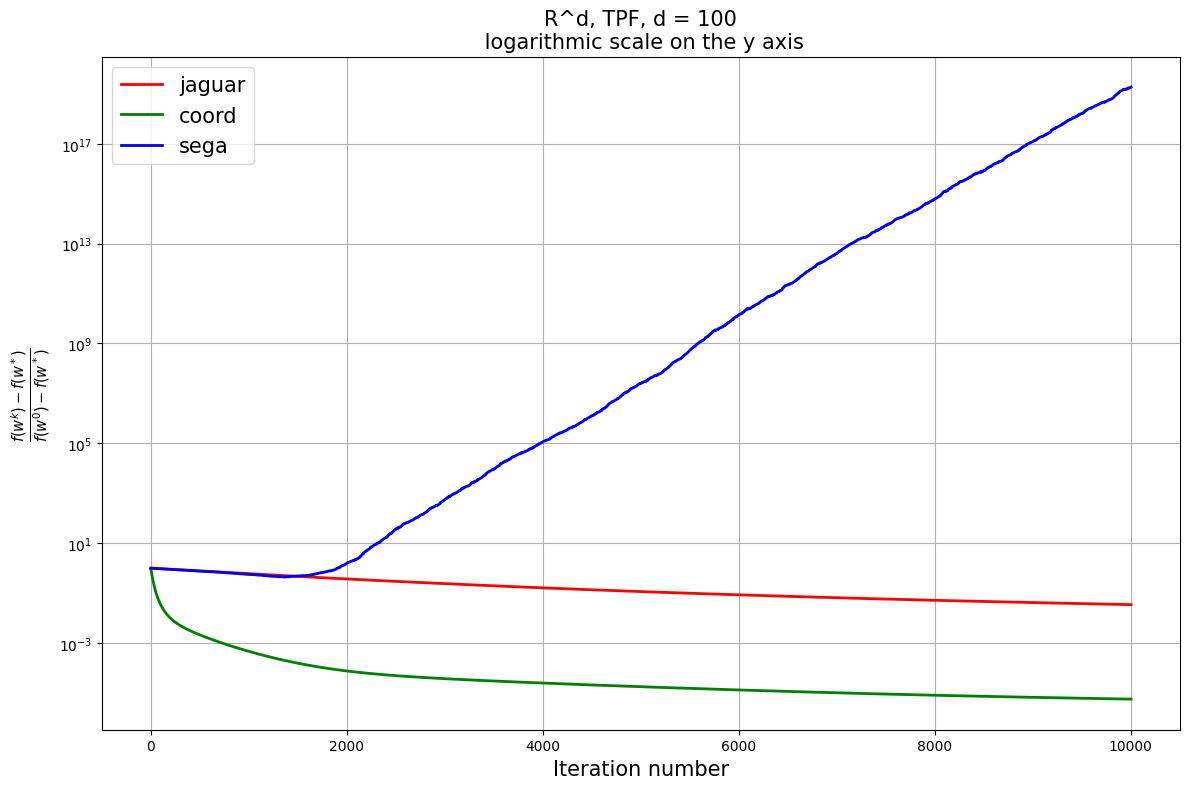

In [311]:
title = f"R^d, TPF, d = {d}"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'
labels = [
    'jaguar',
    'coord',
    'sega'
]
iterations = range(1, len(errors) + 1)

optimizers.make_err_plot(oracle_calls, errors, y_label=y_label, labels=labels, title=title)

# Non-Linear Least Squares

In [ ]:
def nlls():